<a href="https://colab.research.google.com/github/smartrecycling2023/RS/blob/main/Rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before we start, we make coral usb and webcam connections

1) We type the necessary commands in the raspberry terminal and install the libraries

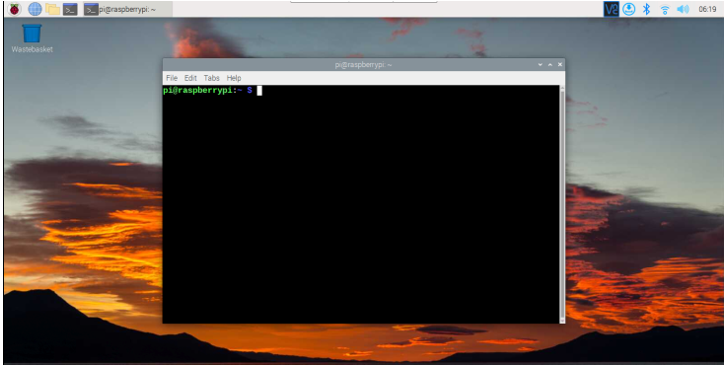

In [ ]:
sudo apt-get update

sudo apt-get upgrade

pip install tensorflow

pip install opencv-python

pip install numpy

pip install keras

pip install pigpio

pip install time

sudo apt-get update && sudo apt-get install python3-rpi.gpio

sudo apt-get update && sudo apt-get install python3-pigpio

sudo pigpiod

https://forums.raspberrypi.com/viewtopic.php?t=340847

CORAL USB:

echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

sudo apt-get update

sudo apt-get install libedgetpu1-std

sudo apt-get install libedgetpu1-max



##sudo pigpiod this command must be run again every time the raspberry pi is rebooted to activate the engines

2) all that remains is to write the code

In [ ]:
import os  # import libraries
import cv2
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter
from pycoral.adapters import common
from pycoral.adapters import classify
import pigpio
import time
import RPi.GPIO as GPIO
import numpy as np

# Define the path to the TFLite model converted for use with Edge TPU
modelPath = '/home/admin/Desktop/TF/model_edgetpu.tflite'

# Define the path to the labels file that was downloaded with the model
labelPath = '/home/admin/Desktop/TF/labels.txt'

# Define GPIO pins for servos
servo1 = 23
servo2 = 24
servo3 = 25
servo4 = 21

# Initialize PWM (Pulse Width Modulation) for servo control using pigpio library
pwm = pigpio.pi()
pwm.set_mode(servo1, pigpio.OUTPUT)
pwm.set_mode(servo2, pigpio.OUTPUT)
pwm.set_mode(servo3, pigpio.OUTPUT)
pwm.set_mode(servo4, pigpio.OUTPUT)

# Set PWM frequency for servos
pwm.set_PWM_frequency(servo1, 50)
pwm.set_PWM_frequency(servo2, 50)
pwm.set_PWM_frequency(servo3, 50)
pwm.set_PWM_frequency(servo4, 50)

# Set initial servo positions
pwm.set_servo_pulsewidth(servo1, 500)
time.sleep(1)
pwm.set_servo_pulsewidth(servo2, 500)
time.sleep(1)
pwm.set_servo_pulsewidth(servo3, 500)
time.sleep(1)
pwm.set_servo_pulsewidth(servo4, 500)
time.sleep(1)

# Function to classify an image using the provided TFLite interpreter
def classifyImage(interpreter, image):
    size = common.input_size(interpreter)
    common.set_input(interpreter, cv2.resize(image, size, fx=0, fy=0, interpolation=cv2.INTER_CUBIC))
    interpreter.invoke()
    return classify.get_classes(interpreter)

def main():
    # Load the model onto the TF Lite Interpreter
    interpreter = make_interpreter(modelPath)
    interpreter.allocate_tensors()
    labels = read_label_file(labelPath)

    # Open the video capture device
    cap = cv2.VideoCapture(0)
    last_detection_cam = 0 #"cam" stands for glass
    last_detection_metal = 0  #"metal" stands for metal
    last_detection_plastik = 0 #"plastik" stands for plastic
    last_detection_kompost = 0 #"kompost" stands for compost

    while cap.isOpened():
        # Read a frame from the video capture device
        ret, frame = cap.read()
        if not ret:
            break

        # Flip the image horizontally
        frame = cv2.flip(frame, 1)

        # Classify and display the image
        results = classifyImage(interpreter, frame)
        cv2.imshow('frame', frame)

        # Extract information about the detected object
        detected_label = labels[results[0].id]
        confidence_score = results[0].score
        print(f'Detected Label: {detected_label}, Score: {confidence_score}')

        # Control the servos based on the detected object and confidence score
        if detected_label == 'cam' and confidence_score > 0.9: #glass
            pwm.set_servo_pulsewidth(servo1, 1700)
            last_detection_cam = time.time()
        elif detected_label == 'metal' and confidence_score > 0.9: #metal
            pwm.set_servo_pulsewidth(servo2, 1700)
            last_detection_metal = time.time()
        elif detected_label == 'kompost' and confidence_score > 0.9: #compost
            pwm.set_servo_pulsewidth(servo3, 1700)
            last_detection_kompost = time.time()
        elif detected_label == 'plastik' and confidence_score > 0.9: #plastic
            pwm.set_servo_pulsewidth(servo4, 1700)
            last_detection_plastik = time.time()

        # Reset servo positions after a certain duration if no detection
        if time.time() - last_detection_cam > 4:
            pwm.set_servo_pulsewidth(servo1, 500)
        if time.time() - last_detection_metal > 4:
            pwm.set_servo_pulsewidth(servo2, 500)
        if time.time() - last_detection_kompost > 4:
            pwm.set_servo_pulsewidth(servo3, 500)
        if time.time() - last_detection_plastik > 4:
            pwm.set_servo_pulsewidth(servo4, 500)

        # Check for the 'q' key press to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture device and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()


3) Lassen Sie uns die notwendigen Verbindungen auf dem Raspberry Pi herstellen

red colored output of the motors vcc(5V) on the raspberry
black colored cables of motors gnd(-)
The yellow colored output of the motors is connected to the following pins

servo1 = 23
servo2 = 24
servo3 = 25
servo4 = 21

4) Download the model file and extract the folder